
# 01 — Shots Analysis (StatsBomb Open Data)

**Obiettivi**
- Leggere eventi partita in Pandas
- Filtrare solo i tiri
- Creare tabella con: **minuto, giocatore, xG, esito**
- Mini–grafico a barre: **xG cumulato nel tempo**

> Suggerimento: esegui le celle **dall'alto verso il basso**. Se non hai ancora il path del file eventi, compila prima la cella **Config** qui sotto.


In [1]:

# --- Setup: import ---
import json
import os
import math

import pandas as pd
import matplotlib.pyplot as plt

print("Pandas:", pd.__version__)
try:
    import numpy as np
    print("NumPy:", np.__version__)
except Exception as e:
    print("NumPy non disponibile:", e)


Pandas: 2.3.1
NumPy: 2.3.2



## Config
Imposta il percorso del file **events** (StatsBomb Open Data) per una singola partita.

- Se hai clonato `statsbomb-open-data`, di solito i file si trovano in una cartella simile a:
  `.../statsbomb-open-data/data/events/<MATCH_ID>.json`
- Esempio Windows (aggiorna il percorso con il tuo!):
  `C:\\Users\\<tuo_utente>\\Documents\\football-analytics\\notebooks\\data\\raw\\statsbomb-open-data\\data\\events\\7584.json`


In [19]:

# --- Config: da personalizzare ---
MATCH_ID = 7584
EVENTS_FILE = fr"C:\Users\AndreaT\Documents\football-analytics\data\raw\statsbomb-open-data\data\events\{MATCH_ID}.json"  

# cartelle output (CSV + figure) relative alla repo (modifica se vuoi)
OUTPUT_CSV = "data/processed"
OUTPUT_FIG = "reports/figures"

os.makedirs(OUTPUT_CSV, exist_ok=True)
os.makedirs(OUTPUT_FIG, exist_ok=True)

assert os.path.exists(EVENTS_FILE), f"File non trovato: {EVENTS_FILE}"
print("OK, user file:", EVENTS_FILE)


OK, user file: C:\Users\AndreaT\Documents\football-analytics\data\raw\statsbomb-open-data\data\events\7584.json



## Caricamento eventi
Carichiamo il JSON degli eventi e lo **appiattiamo** in un `DataFrame` con `pandas.json_normalize`.


In [4]:

# --- Load: events -> DataFrame piatto ---
with open(EVENTS_FILE, "r", encoding="utf-8") as f:
    events = json.load(f)

df = pd.json_normalize(events, sep=".")
print("Eventi totali:", len(df))
df.head(3)


Eventi totali: 3715


,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,...,pass.technique.name,pass.through_ball,miscontrol.aerial_won,dribble.nutmeg,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_committed.advantage,foul_won.advantage
0,879a49e5-6c6f-4c77-8da1-5ea41bbb719e,1,1,00:00:00.000,0,0,1,0.0,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4c39c2d8-deec-44d3-b494-6e7fe02c091d,2,1,00:00:00.000,0,0,1,0.0,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,af5477e2-5680-4ba3-b28f-ab07d631294b,3,1,00:00:00.000,0,0,1,NaN,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## Filtrare i tiri
I tiri in StatsBomb sono righe con `type.name == "Shot"`.


In [18]:

# --- Filter: solo tiri ---
mask_shots = df.get("type.name").eq("Shot")
shots = df[mask_shots].copy()
print("Tiri trovati:", len(shots))

# campi utili (lascio 'get' per robustezza se qualche chiave manca)
cols_keep = [
    "minute",
    "second",
    "period",
    "player.name",
    "team.name",
    "shot.statsbomb_xg",
    "shot.outcome.name",
]

# Aggiungo colonne se assenti
for c in cols_keep:
    if c not in shots.columns:
        shots[c] = pd.NA

# coerce numerici e NaN gestiti
shots["minute"] = pd.to_numeric(shots["minute"], errors="coerce").fillna(0).astype(int)
shots["second"] = pd.to_numeric(shots["second"], errors="coerce").fillna(0).astype(int)

# ordiniamo temporalmente (minuto, secondo)
shots = shots.sort_values(["minute", "second"], kind="mergesort").reset_index(drop=True)

# time string mm:ss
shots["time"] = shots["minute"].map("{:02d}".format) + ":" + shots["second"].map("{:02d}".format)

# Goal/No Goal Column
shots["Goal/NoGoal"] = np.where(shots["shot.outcome.name"] == 'Goal', "Goal", "No Goal")

# rinomina colonne finali
shots_small = shots.rename(
    columns={
        "minute": "Minute",
        "player.name": "Player",
        "period": "Period",
        "team.name": "Team",
        "shot.statsbomb_xg": "xG",
        "shot.outcome.name": "Outcome",
        "Goal/No Goal": "Goal/NoGoal"
    }
)[["Minute", "time", "Period", "Player", "Team", "xG", "Outcome", "Goal/NoGoal"]]

# stampa un'anteprima
shots_small.head(30)


Tiri trovati: 40


,Minute,time,Period,Player,Team,xG,Outcome,Goal/NoGoal
0,0,00:54,1,Shinji Kagawa,Japan,0.038845,Off T,No Goal
1,9,09:14,1,Gen Shōji,Japan,0.005453,Off T,No Goal
2,15,15:13,1,Axel Witsel,Belgium,0.023292,Blocked,No Goal
3,15,15:58,1,Vincent Kompany,Belgium,0.038868,Wayward,No Goal
4,16,16:33,1,Romelu Lukaku Menama,Belgium,0.068029,Blocked,No Goal
5,17,17:16,1,Vincent Kompany,Belgium,0.062155,Wayward,No Goal
6,17,17:17,1,Vincent Kompany,Belgium,0.096837,Off T,No Goal
7,20,20:10,1,Romelu Lukaku Menama,Belgium,0.053347,Blocked,No Goal
8,24,24:53,1,Romelu Lukaku Menama,Belgium,0.299050,Wayward,No Goal
9,26,26:05,1,Kevin De Bruyne,Belgium,0.074352,Blocked,No Goal



## Tabella tiri (preview)
Mostriamo la tabella con **Minute, time, Player, Team, xG, Outcome**.


In [14]:

# --- Anteprima tabella ---
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Shots — anteprima", shots_small)
except Exception as e:
    print("Preview interattiva non disponibile in questo ambiente:", e)
    display(shots_small.head(20))


Preview interattiva non disponibile in questo ambiente: No module named 'caas_jupyter_tools'


,Minute,time,Period,Player,Team,xG,Outcome
0,0,00:54,1,Shinji Kagawa,Japan,0.038845,Off T
1,9,09:14,1,Gen Shōji,Japan,0.005453,Off T
2,15,15:13,1,Axel Witsel,Belgium,0.023292,Blocked
3,15,15:58,1,Vincent Kompany,Belgium,0.038868,Wayward
4,16,16:33,1,Romelu Lukaku Menama,Belgium,0.068029,Blocked
5,17,17:16,1,Vincent Kompany,Belgium,0.062155,Wayward
6,17,17:17,1,Vincent Kompany,Belgium,0.096837,Off T
7,20,20:10,1,Romelu Lukaku Menama,Belgium,0.053347,Blocked
8,24,24:53,1,Romelu Lukaku Menama,Belgium,0.299050,Wayward
9,26,26:05,1,Kevin De Bruyne,Belgium,0.074352,Blocked



## Salvataggio CSV
Salviamo la tabella dei tiri in `data/processed/<match_id>_shots.csv` (se `match_id` è presente nel file).


In [20]:

# --- Save CSV ---
csv_name = f"{MATCH_ID}_shots.csv" if {MATCH_ID} else "shots.csv"
csv_path = os.path.join(OUTPUT_CSV, csv_name)

shots_small.to_csv(csv_path, index=False, encoding="utf-8")
print("CSV salvato in:", csv_path)


CSV salvato in: data/processed\7584_shots.csv



## Mini–grafico a barre: xG **cumulato** nel tempo
Per semplicità:
1. sommiamo l'xG per **minuto**;
2. calcoliamo il **cumulato**;
3. grafico a **barre** minuto → xG cumulato.

> Nota: il cumulato cresce a scalini quando ci sono tiri multipli nello stesso minuto.


Figura salvata in: reports/figures\cumxg.png


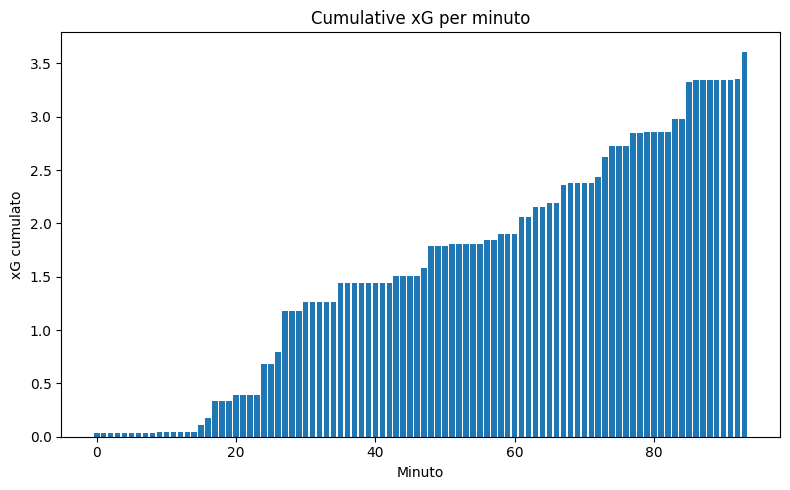

In [ ]:

# --- Cumulative xG per minuto (bar chart) ---
# somma xG per minuto (se xG non presente, imposta 0)
xg_per_min = shots.copy()
xg_per_min["xG"] = pd.to_numeric(xg_per_min.get("shot.statsbomb_xg"), errors="coerce").fillna(0.0)

if len(xg_per_min) == 0:
    raise ValueError("Nessun tiro trovato: impossibile generare il grafico.")

max_minute = int(xg_per_min["minute"].max())
minute_index = pd.Index(range(0, max_minute + 1), name="Minute")

xg_per_min = (
    xg_per_min.groupby("minute", dropna=False)["xG"]
    .sum()
    .reindex(minute_index, fill_value=0.0)
)

xg_cum = xg_per_min.cumsum()

plt.figure(figsize=(8, 5))  # mini-grafico
plt.bar(xg_cum.index, xg_cum.values)
plt.xlabel("Minuto")
plt.ylabel("xG cumulato")
title_mid = f" — match {MATCH_ID}" if MATCH_ID else ""
plt.title("Cumulative xG per minuto" + title_mid)
plt.tight_layout()

fig_name = f"{MATCH_ID}_cumxg.png" if MATCH_ID else "cumxg.png"
fig_path = os.path.join(OUTPUT_FIG, fig_name)
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print("Figura salvata in:", fig_path)
plt.show()

# --- Grafico step xG cumulato (line plot) ---
plt.figure(figsize=(8, 5))
plt.step(xg_cum.index, xg_cum.values, where="post", linewidth=2)
plt.xlabel("Minuto")
plt.ylabel("xG cumulato")
title_mid = f" — match {MATCH_ID}" if MATCH_ID else ""
plt.title("Cumulative xG per minuto (step line)" + title_mid)
plt.tight_layout()

fig_name_step = f"{MATCH_ID}_cumxg_step.png" if MATCH_ID else "cumxg_step.png"
fig_path_step = os.path.join(OUTPUT_FIG, fig_name_step)
plt.savefig(fig_path_step, dpi=150, bbox_inches="tight")
print("Figura step salvata in:", fig_path_step)
plt.show()




## Extra opzionali
- Aggiungi colonna **`Period`** (1°/2° tempo, extra time) usando `period`/`timestamp` se disponibili. **--> `Done`**
- Evidenzia i tiri **Goal** (`Outcome == "Goal"`) con una colonna booleana. **--> `Done`**
- Esporta anche un grafico **step** dell'xG cumulato (linea) per confronto.



## Riproducibilità
Versioni principali (stampa all'inizio): Pandas, NumPy, Matplotlib.
Imposta un **seed** se aggiungi simulazioni/stime.
